<a href="https://colab.research.google.com/github/rakesh4real/APACHE-KAFKA/blob/main/consumers_kafka_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note:** Do **NOT** click `Run All` .Make sure you add addresses in config files as specified **every time** you run this notebook!

# Install Libraries

In [65]:
!pip install kafka-python
!pip install Faker

In [66]:
from google.colab.output import serve_kernel_port_as_window as expose

# 1. Install Kafka and Zookeeper

Download `tgz` file and follow instructions [here](https://kafka.apache.org/quickstart)

In [67]:
!curl -O https://mirrors.estointernet.in/apache/kafka/2.6.0/kafka_2.13-2.6.0.tgz
!tar -xzf kafka_2.13-2.6.0.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62.5M  100 62.5M    0     0  5061k      0  0:00:12  0:00:12 --:--:-- 5974k


`server.properties` for all brokers' and ` zookeeper.properties` for management and sync

**`server.properties`:** (At correct location)

```
advertised.listeners=PLAINTEXT://localhost:9092
.
.
zookeeper.connect=localhost:2181
```

**Note:** Start Zookeeper first

In [ ]:
!cd kafka_2.13-2.6.0 && bin/zookeeper-server-start.sh -daemon config/zookeeper.properties
!cd kafka_2.13-2.6.0 && JMX_PORT=8004 bin/kafka-server-start.sh -daemon config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


The two java processes correspond to zookeeper and the kafka instances.

In [69]:
!ps -ef | grep kafka

root         493       1  0 05:10 ?        00:00:11 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-2.6.0/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=102400 -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-2.6.0/bin/../logs -Dlog4j.configuration=file:bin/../config/log4j.properties -cp /content/kafka_2.13-2.6.0/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-2.6.0/bin/../libs/aopalliance-repackaged-2.5.0.jar:/content/kafka_2.13-2.6.0/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-2.6.0/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-2.6.0/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-2.6.0/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13-2.6.0/bin/../lib

# 2. Setup Kafka Manager

Make sure of java 8+ 

In [ ]:
!java --version

openjdk 11.0.9 2020-10-20
OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)


Below command will create `target` folder upon successful compilation

In [ ]:
!git clone https://github.com/yahoo/CMAK
!cd CMAK && ./sbt clean dist 

In [ ]:
%cd CMAK/target/universal
!unzip cmak-3.0.0.5.zip
%cd cmak-3.0.0.5

Add `<zookeerper-host-addr>:port` in `application.conf`:
```
#cmak.zkhosts="kafka-manager-zookeeper:2181"
cmak.zkhosts="localhost:2181"
```

In [70]:
expose(8081)

<IPython.core.display.Javascript object>

### **Click on the above link 👆 (will not load anything) and run the below 👇 cell. Refresh the page; You will see manager running!**

In [ ]:
"""
Launch manager
"""

!nohup bin/cmak -Dconfig.file=conf/application.conf -Dhttp.port=8081 &

nohup: appending output to 'nohup.out'


# Create new cluster

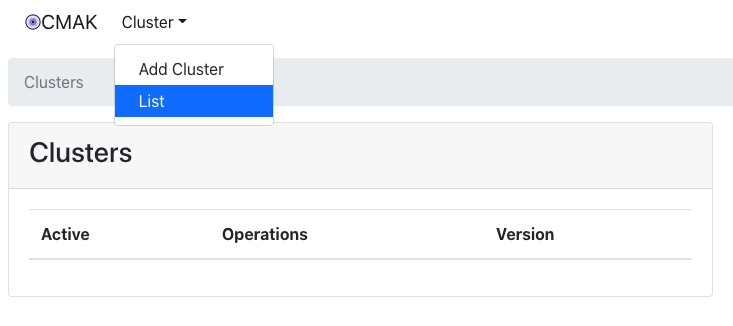

- **Cluster Name:** Give camelCased name. Eg, `TestCluster`
- **Cluster Zookeeper Hosts:** Coma separated addrs w/ ports (if multiple zookeepers) single address w/ port (if single zookeeper). Eg, `localhost:2181`
- [x] Enable JMX Polling (Set JMX_PORT env variable before starting kafka server)
- [x] Poll consumer information (Not recommended for large # of consumers if ZK is used for offsets tracking on older Kafka versions) -- To see how consumer is performing


**Leave others w/ default values** and click on `Save`

### ⭐️ To see the details about created clusters' `Brokers` (or) `Topics` click on the **number** adjacent to them

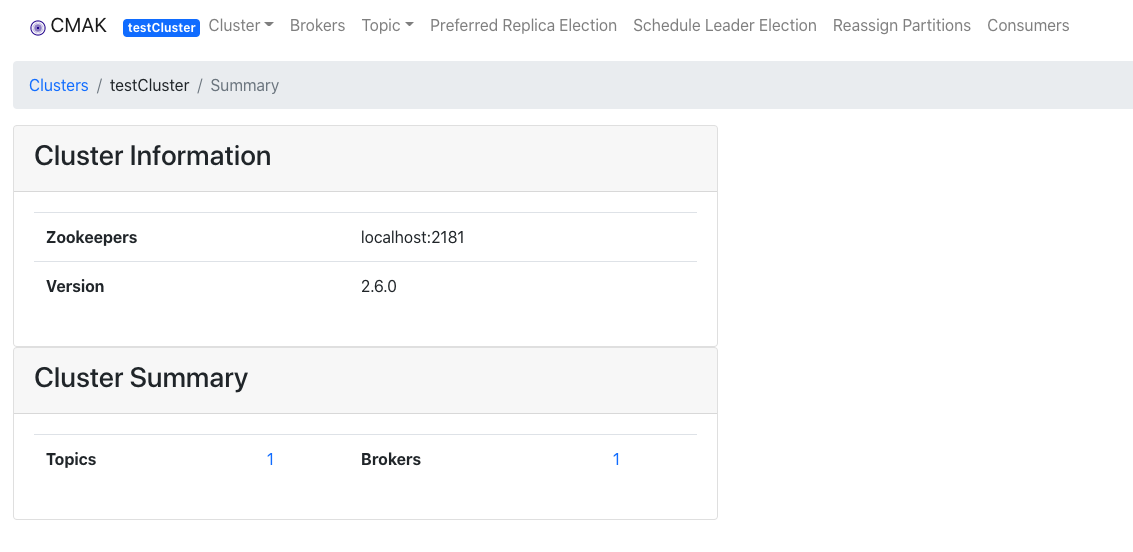

**Note:** You can Modify/Remove created clusters or add more clusters!


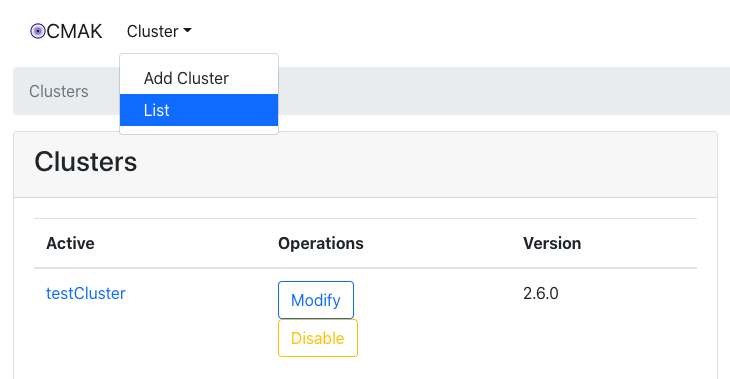

&nbsp;

----

<div style="text-align: center"> end of section </div>

----

&nbsp;

&nbsp;

In [ ]:
"""
run producer in bg

Make this produce data inifinitely ...
"""

# consumer will not run unless producer publishes some data
# inside topic partion



from faker import Faker
fake = Faker()
 
def get_new_reg_user():
  return {
      "name": fake.name(),
      "addr": fake.address(),  
      "bio" : fake.text()    
  } 


import time
import json
from kafka import KafkaProducer
 
# serializer
def json_serializer(data):
  return json.dumps(data).encode("utf-8")
 
# instantiate producer
producer = KafkaProducer(
    bootstrap_servers="localhost:9092",
    value_serializer=json_serializer # takes `data` as input
    )
 
# send data
def run_producer(sleep: int):
  while True: 
    data_to_publish = get_new_reg_user()
    print("sending: ", data_to_publish)

    producer.send(
        topic="reg_users",
        value=data_to_publish
    )
  
    time.sleep(sleep)

run_producer(3) # comment if multiprocessing cell works

# **Consumer in Python**

- Consumer group must be assigned to a consumer (randomly given if not assigned). Consumer groups are important for scalability!
- Consumers consume from topic *partitions*
- Consumers run independantly as a separate process
- Consumers from same group can be on different nodes
- Consumer runs only if producer is running and publishing data

## **Case 1:** 1 Topic, 1 Partition, 1 Consumer


**Note:** The instantiated consumer will directly start consuming messages. No method such as `subscribe` (or) `receive` must be used.

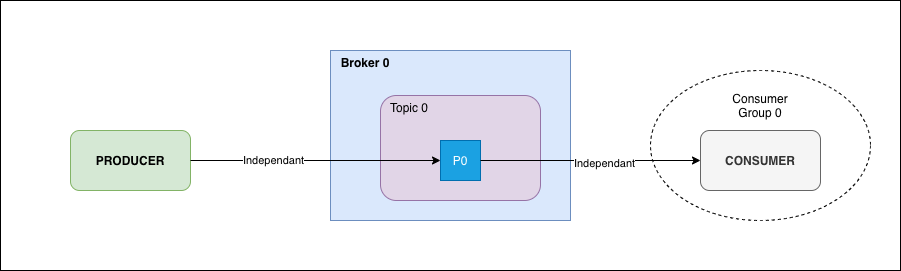

In [ ]:
"""
consumer
"""

from kafka import KafkaConsumer
import json


# define consumer and >>start<< consuming
consumer = KafkaConsumer(
    "reg_users", # topic name
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest', # 'earliest': oldest available message, 'latest': most recent
    group_id='consumer-group-0'
)

# log consumed messages
def log_consumer():
  for msg in consumer:
    print('read: ', json.loads(msg.value))

log_consumer() # comment if multiprocessing cell works

- Consumer group will be created. If not mentioned random group will be created.

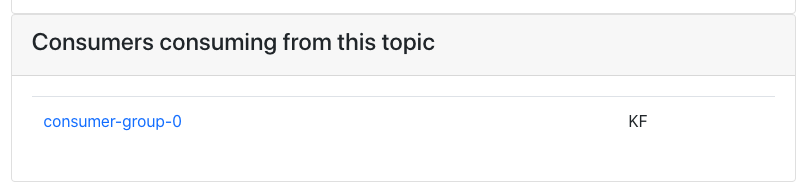

- Before producer is publishing

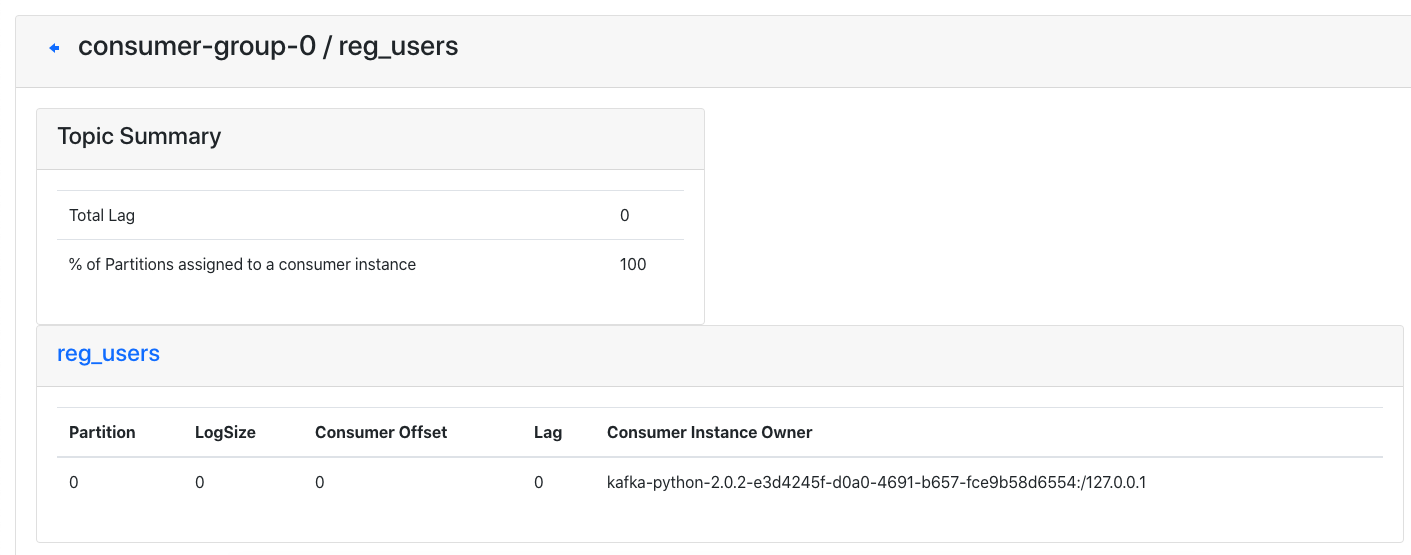

- `Consumer Offset` is always set to the last message. 

In [ ]:
# """
# Emulate producer & consumer
# """
# 
# import multiprocessing 
# 
# producer_proc = multiprocessing.Process(target=run_producer, args=(3, ))
# consumer_proc = multiprocessing.Process(target=log_consumer)
# 
# producer_proc.start()
# consumer_proc.start()
# 
# producer_proc.join()
# consumer_proc.join()
# 
# ! above code is not publishing to partition
# ---------------------------------------------------------------------------------
# producer_proc.terminate()
# usage: https://gist.github.com/rakesh4real/121bbf147da0be9eeb2f77b22b4b8c38

- After reading

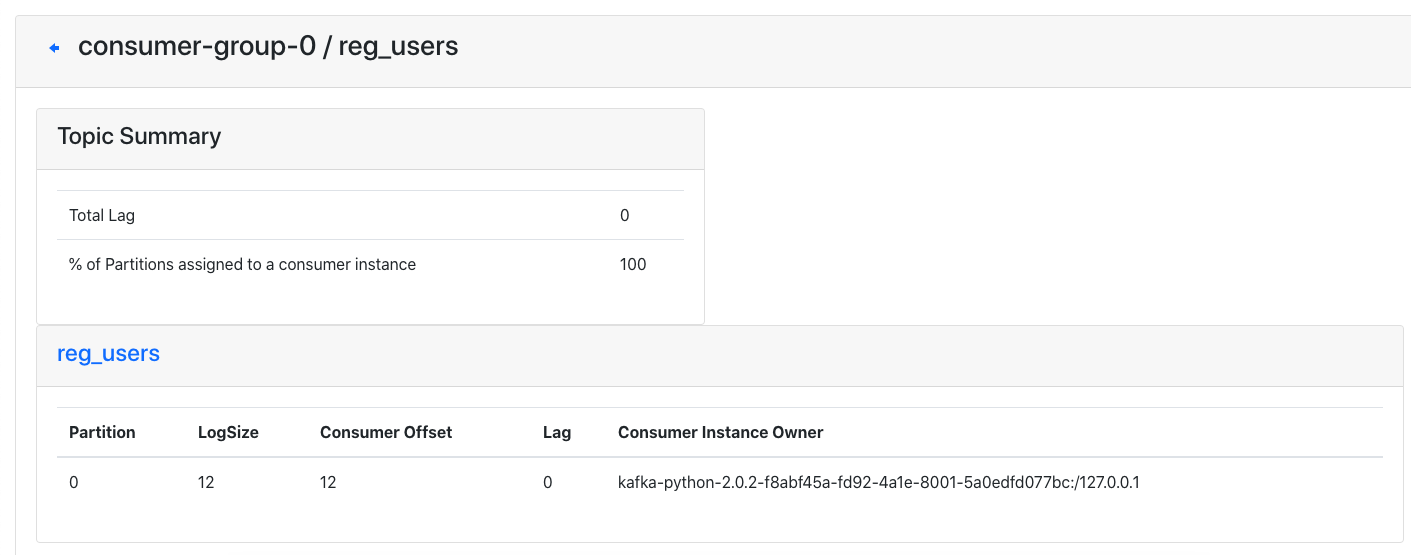

# **Case 2:** 2 Partitions, 1 Consumer

*1 Topic, 1 Producer*

- Consumer is **not** tightly coupled to parttitions. It only need to to know `topic` not it's partitions
- It consumes from all partitons in round-robin (one after another)


*Same code as above for consumer but create topic w/ two partitions and let producer publish randomly*


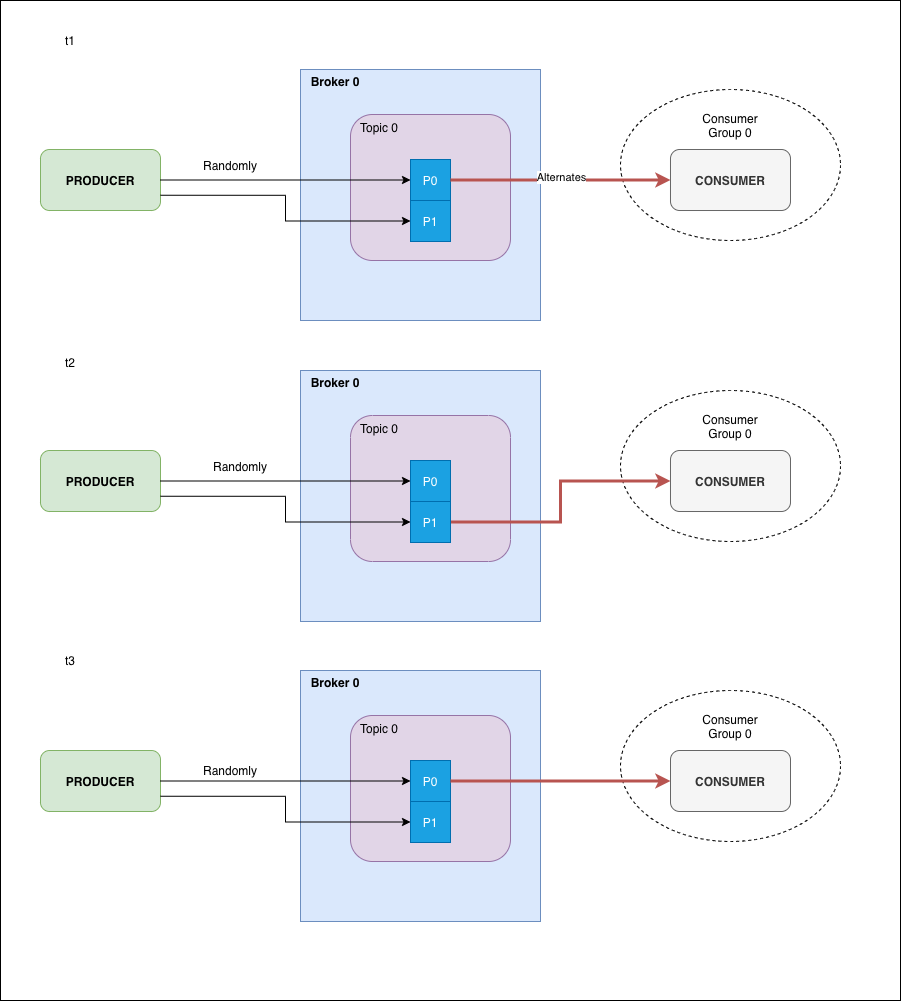

# **Case 3:** 1 Topic, 1 Partition, 2 Consumers (same and difft. group)

- Same partition **cannot** be assigned to multiple patitions in **same group**!

> *Same code as above. Just run `python consumer.py` in two two times in different terminals. (Will create different instances of it as they are independant processes)*
>
> *For third example (below) just change `group_id='consumer-group-1'` and then run the second instance.*

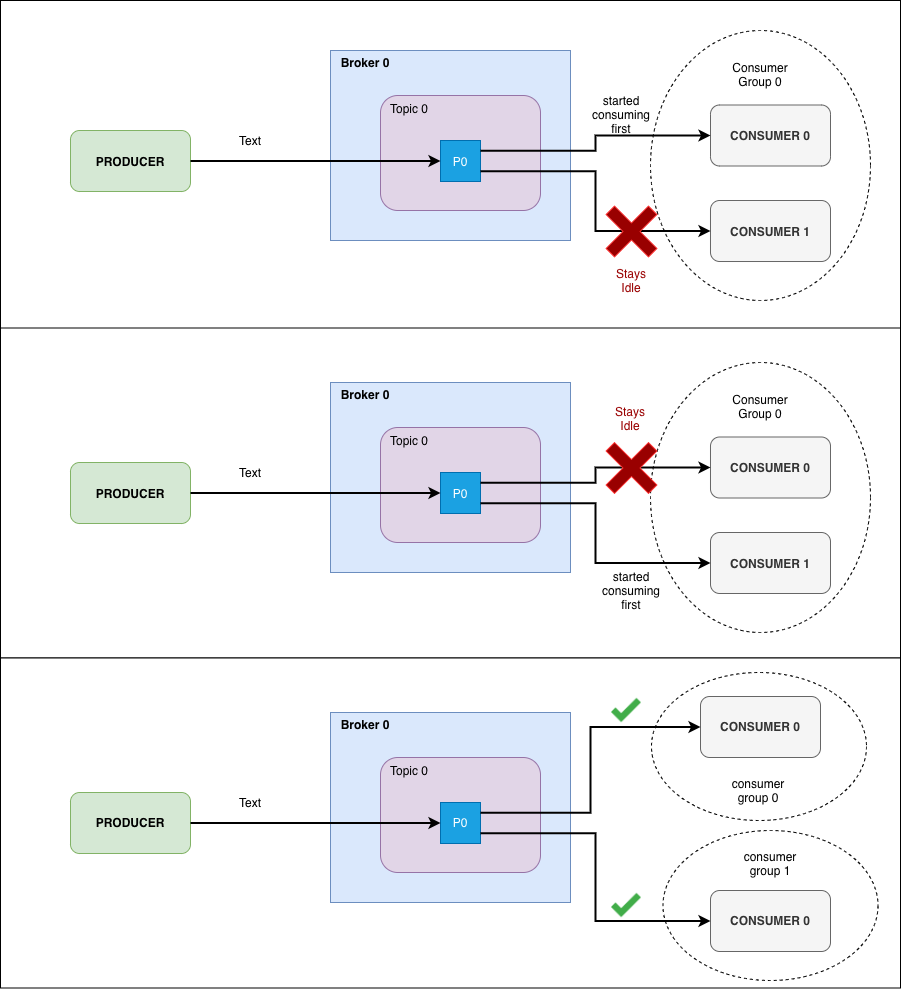

# **Case 4:** 2 Partition, 2 Consumers (same group)

*1 Topic, 1 Producer*

- *Same code as above. Just put `2` partitions while creating topic using CMAK*
- If there are 3 partitions and 2 consumers, the extra partiton is consumed in round-robin fashion.

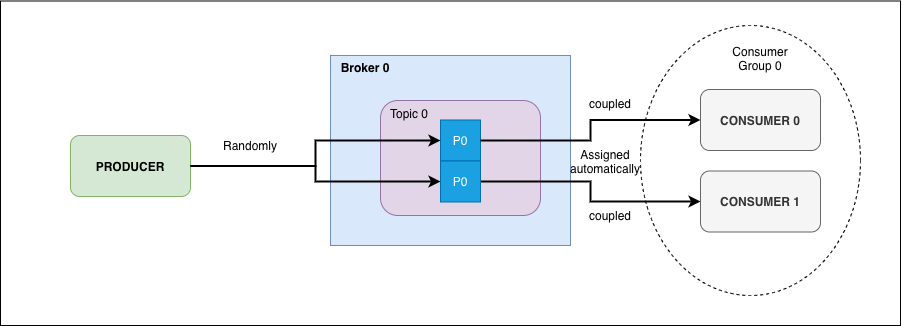